# Predicting Stroke
Author: Necky Tran <br>
Date: 06/06/23

### Table of Contents

1. [Introduction](#Introduction)
2. [Wrangling](#Wrangling)
3. [Statistical Analysis](#Statistical_Analysis)
4. [Logistic Regression](#Logistic)
5. [SMOTE](#Smote)
6. [Summary](#Summary)

# Introduction
This notebook contains an analysis of a of a US Health Insurance Dataset. The dataset is sourced from Kaggle:
- 'https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset'

The dataset was cleaned and analyzed to generate a logistic model to predict likelyhood of stroke.

In [1]:
# load standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in and check data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The data has been successfully loaded


# Wrangling
- Exploratory Data Analysis
    - Deal with NaNs and Duplicates
    - Explore each column
    - Convert categorical columns into  numerical

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 5110 rows and 12 columns

The [bmi] column has some missing values, we can explore this further 

In [5]:
# Check which columns have NaN values
#.isna() returns a dataframe of T/F for any element that is missing
#.any() tells us if there are any Trues in that column
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [6]:
# calculate percentage of missing data
df.isna().mean()*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

The BMI column has some NAs, about 4% of the total data. We can explore it futher to make a decision one whether to drop or impute <br>

In [7]:
# find rows of data where bmi is missing
df[df['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


There are 201 rows where the bmi value is missing. <br>


Look into the distribution of the BMI column:
- so we can either impute with mean or median values

 28.86 is the mean BMI
 28.0 is the median BMI


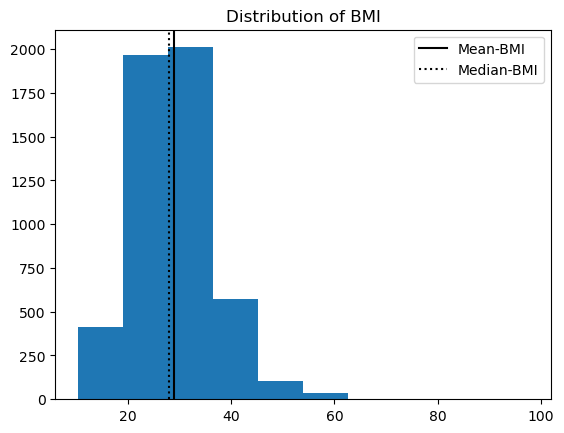

In [33]:
# histogram of BMI
plt.hist(df['bmi'])

# add lines for the mean and median values
plt.axvline(df['bmi'].mean(),linestyle = 'solid',label = "Mean-BMI", color = 'black')
plt.axvline(df['bmi'].median(),linestyle = 'dotted',label = "Median-BMI", color = 'black')

# title
plt.title('Distribution of BMI')

# legend
plt.legend(loc='upper right');

# print the mean BMI
print(f" {round(df['bmi'].mean(), 2)} is the mean BMI")

# print the median BMI
print(f" {df['bmi'].median()} is the median BMI")

The mean and median BMI are very similar which means this data is symetrically distributed around a central value. There are no extreme outliers pulling the mean away from the median. It would be appropriate to use a mean imputation on the missing data.

Lets check for duplications before we impute

In [10]:
#check for duplicated values
df.duplicated().sum()

0

There are no duplicated rows in the Dataset

Impute missing [bmi] data with the mean

In [11]:
# mean imputation
df['bmi'] = np.where(df['bmi'].isna(), 28, df['bmi'])

In [12]:
# check for missing values again
df['bmi'].isna().sum()

0

The missing values have been successfully imputed with the mean.

Explore the columns of the dataset by visualizing each invididually

In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Columns [gender], [every_married], [work_type], [Residence_type], and [smoking_status] are object columns that should be numerically encoded

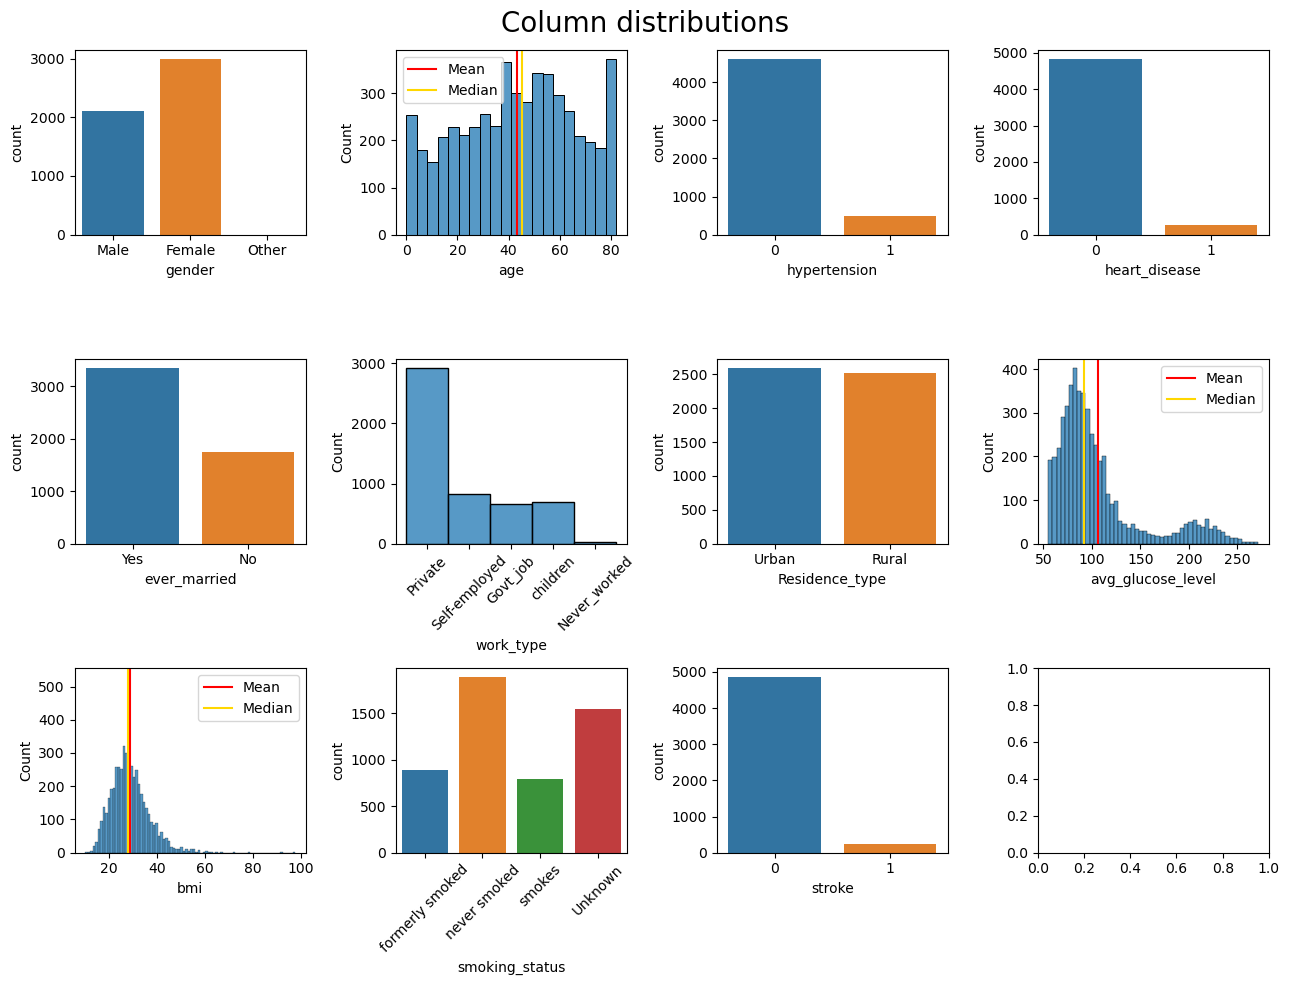

In [14]:
# explore distribution of every column

plt.subplots(3,4, figsize = (13,10))
plt.suptitle('Column distributions', size =20)

plt.subplot(3,4,1)
sns.countplot(x = df['gender'])
#plt.title('Gender')

plt.subplot(3,4,2)
sns.histplot(x = df['age'])
plt.axvline(df['age'].mean(), c='red', label='Mean')
plt.axvline(df['age'].median(), c='gold', label='Median')
plt.legend()
#plt.title('Age')

plt.subplot(3,4,3)
sns.countplot(x = df['hypertension'])
#plt.title('Hypertension')

plt.subplot(3,4,4)
sns.countplot(x = df['heart_disease'])
#plt.title('Heart Disease')

plt.subplot(3,4,5)
sns.countplot(x = df['ever_married'])
#plt.title('Married')

plt.subplot(3,4,6)
sns.histplot(x = df['work_type'])
#plt.title('Work Type')
plt.xticks(rotation=45)

plt.subplot(3,4,7)
sns.countplot(x = df['Residence_type'])
# plt.title('Residence')

plt.subplot(3,4,8)
sns.histplot(x = df['avg_glucose_level'])
plt.axvline(df['avg_glucose_level'].mean(), c='red', label='Mean')
plt.axvline(df['avg_glucose_level'].median(), c='gold', label='Median')
plt.legend()
# plt.title('Glucose level')

plt.subplot(3,4,9)
sns.histplot(x = df['bmi'])
plt.axvline(df['bmi'].mean(), c='red', label='Mean')
plt.axvline(df['bmi'].median(), c='gold', label='Median')
plt.legend()
# plt.title('bmi')

plt.subplot(3,4,10)
sns.countplot(x = df['smoking_status'])
# plt.title('Smoker')
plt.xticks(rotation=45)

plt.subplot(3,4,11)
sns.countplot(x = df['stroke'])
# plt.title('stroke')

plt.tight_layout()

### Observations into the features: <br>
gender: more females than males in the dataset <br>
age: most ages are normally distributed around 40, there is a large count of 80+ people <br>
hypertension: most do not have hypertension <br>
heart_disease: most do not have heart disease <br>
ever_married: larger proportion of people are married <br>
work_type: majority of people are privately employed <br>
residence_type: the distribution between urban and rural residence is about equal <br>
avg_glucose_level: the distribution has a right skew, most are centered around the median (~80) <br>
bmi: looks normally distributed around a mean of ~29 (This column was mean imputed)<br>
smoking_status: most have never smoked or formerly smoked <br>
stroke: most have not experienced a stroke <br>


Our current target distribution is heavily skewed towards non-stroke cases. As a result, our model will exhibit a strong bias towards predicting no stroke, potentially leading to increased false negative predictions when applied to new and unseen data. To address this issue, we can rectify the imbalance using a scikit-learn package (SMOTE). Our initial approach will involve creating a base model first and then upsampling with SMOTE to achieve a more balanced and representative dataset<br>

Before modelling, create dummy variables out of all the categorical variables

In [15]:
# Get a list of all categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Display the encoded DataFrame
print(df_encoded)

         id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21  28.0   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75  28.0   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  gender_Male  gender_Other  ever_married_Yes  \
0          1            1             

In [16]:
# view new encoded dataframe
df_encoded.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,1,0,0
1,51676,61.0,0,0,202.21,28.0,1,0,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,0,1,0


## Statistical Analysis <a name="Statistical_Analysis"></a>

Check for multicolinearity with a heatmap

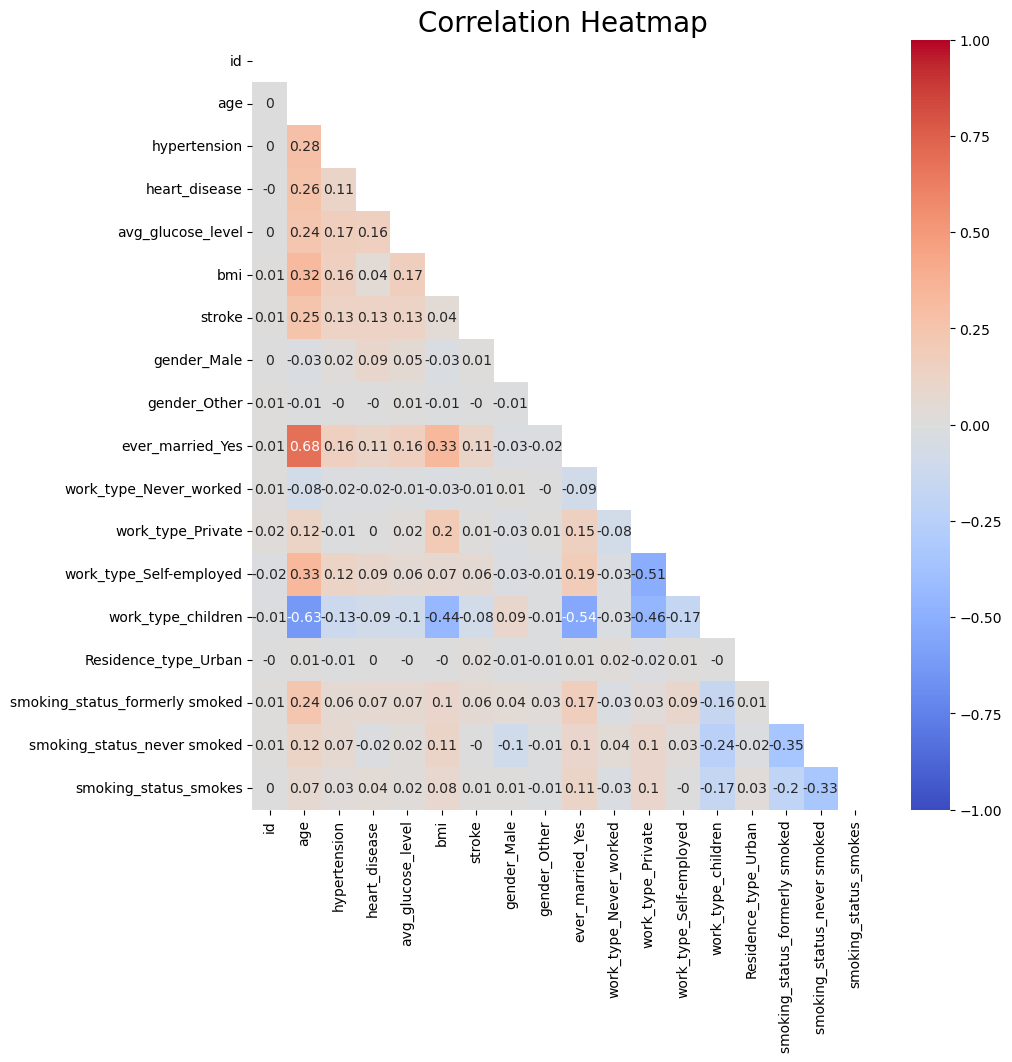

In [17]:
# heatmap 
plt.figure(figsize=(10,10))
sns.heatmap(df_encoded.corr().round(2), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, mask = np.triu(df_encoded.corr()) )
plt.title('Correlation Heatmap', size = 20)
plt.show()

### Observations into the features: <br>
[age] is positively correlated with [ever_married_yes] and negatively correlated with [work_type_children] <br>
[bmi] is correlated with positively correlated with [ever_married_yes] and negatively correlated with [work_type_children] <br>
[work_type_children] is negatively correlated with [ever_married_yes] and negatively correlated with [work_type_private] <br>

All the work types are negatively correlated with each other, it would be wise to remove some of them. From our countplot, most people work in the private sector. So we can remove all but the [work_type_private] as it hold the most data <br>

I will also remove [ever_married_yes] because it is correlated with age, and age is a feature i want to keep <br>

Also drop the [id] column

In [18]:
# drop [ever_married_Yes], ['work_type_children], [work_type_Self-employed], [id]
df_encoded.drop(['ever_married_Yes', 'work_type_children', 'work_type_Self-employed', 'id'], axis = 1, inplace = True)

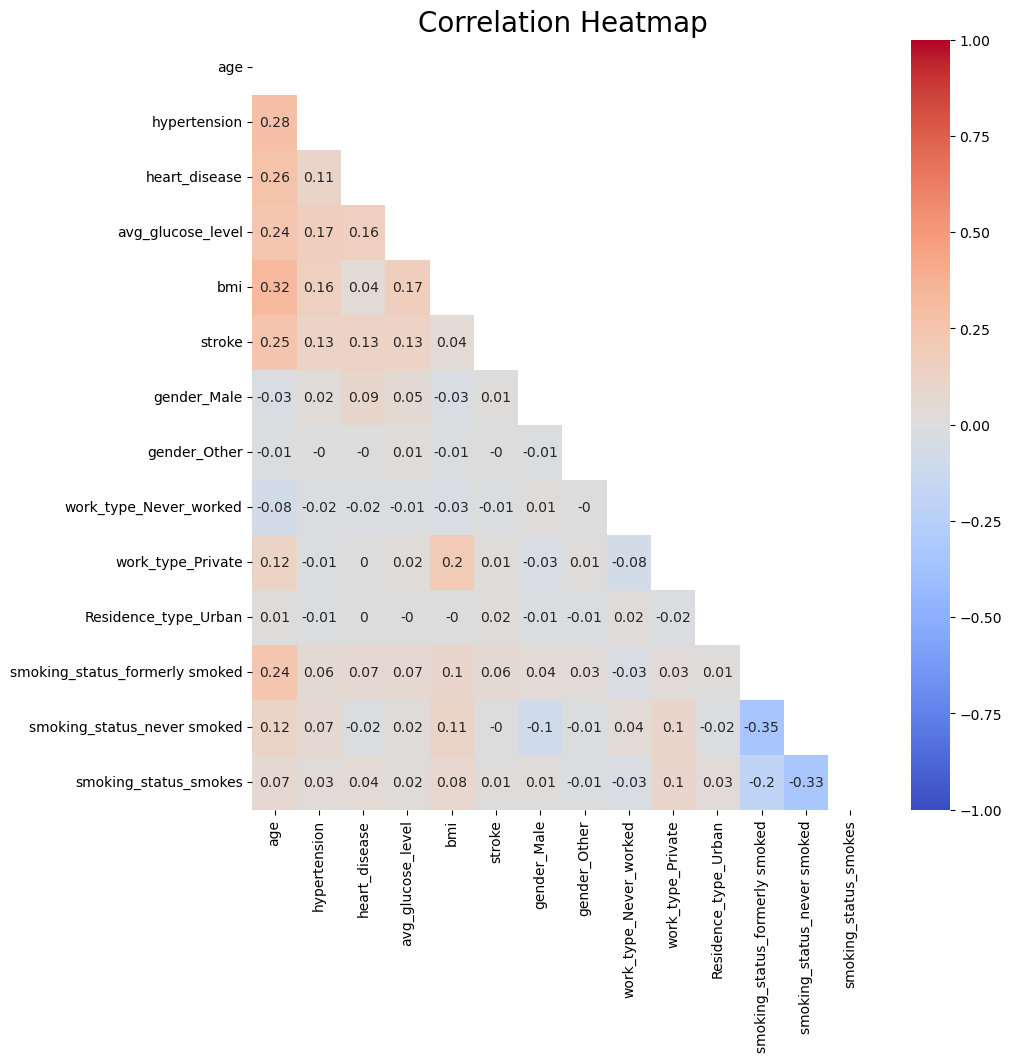

In [19]:
# heatmap, check for correlations again
plt.figure(figsize=(10,10))
sns.heatmap(df_encoded.corr().round(2), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, mask = np.triu(df_encoded.corr()) )
plt.title('Correlation Heatmap', size = 20)
plt.show()

We have removed the strongly correlated variables and are comfortable with starting our modelling process

## Logistic Regression <a name="Logistic"></a>

- Run a Logistic Regression model using stats package
- Evaluate model with confusion matrix and F1 scores

In [20]:

import statsmodels.api as sm

# target
y = df_encoded['stroke']

# features
x = df_encoded.drop('stroke', axis=1)

# !! Add constant to our X !!
X_0 = sm.add_constant(x)



In [21]:
X_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   const                           5110 non-null   float64
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   avg_glucose_level               5110 non-null   float64
 5   bmi                             5110 non-null   float64
 6   gender_Male                     5110 non-null   uint8  
 7   gender_Other                    5110 non-null   uint8  
 8   work_type_Never_worked          5110 non-null   uint8  
 9   work_type_Private               5110 non-null   uint8  
 10  Residence_type_Urban            5110 non-null   uint8  
 11  smoking_status_formerly smoked  5110 non-null   uint8  
 12  smoking_status_never smoked     51

In [22]:
# Instantiate the logistic regression model 
logreg = sm.Logit(y.astype(float), X_0.astype(float))

In [23]:
# Fit the model (this returns a separate object with the parameters)
logreg_results = logreg.fit()

# Display the results 
logreg_results.summary()

         Current function value: 0.155030
         Iterations: 35


c:\Users\trann\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5096
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.2040
Time:                        11:30:35   Log-Likelihood:                -792.20
converged:                      False   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 1.230e-78
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -7.7438      0.552    -14.036      0.000      -8.825      -6.662
age                                0.0708      0.005     13.111      0.000       0.060       0.081
hypertension                       0.4046      0.164      2.460      0.014       0.082       0.727
heart_disease                      0.2921      0.191      1.533      0.125      -0.081       0.666
avg_glucose_level                  0.0041      0.001      3.400      0.001       0.002       0.006
bmi                               -0.0013      0.011     -0.118      0.906      -0.023       0.021
gender_Male                        0.0089      0.141      0.063      0.950      -0.268       0.286
gender_Other                      -3.3530     66.450     -0.050      0.960    -133.592     126.886
work_type_Never_worked           -16.4053   1.78e+04     -0.001      0.999   -3.48e+04    3.48e+04
work_type_Private                  0.2672      0.142      1.885      0.059      -0.011       0.545
Residence_type_Urban               0.0915      0.138      0.663      0.507      -0.179       0.362
smoking_status_formerly smoked     0.0451      0.206      0.218      0.827      -0.359       0.450
smoking_status_never smoked       -0.1547      0.196     -0.789      0.430      -0.539       0.230
smoking_status_smokes              0.1465      0.231      0.635      0.525      -0.306       0.599
==================================================================================================
"""

[bmi], [gender_Male], [gender_Other], [work_type_Never_worked], [smoking_status_formerly smoked], [smoking_status_smokes] have pvalues above 0.05

These are the columns to consider dropping or changing after we evaluate the accuracy and F1 scores


We can check for model accuracy

In [24]:
# Getting the model predictions as probabilities
y_prob = logreg_results.predict(X_0)

# Going from soft predictions (probabilities) to hard predictions (1 or 0)
y_pred = np.where(y_prob >= 0.5, 1, 0)

# Calculating accuracy 
acc = (y_pred == y).mean()

# Print the accuracy score
print(f'Model accuracy = {round(100*acc, 3)}%')

Model accuracy = 95.147%


The model accuracy is high due to the imbalance of our target variable. We can check threshold values and see how accuracy changes

,Decision Threshold,Accuracy
0,0.0,0.048728
1,0.1,0.841292
2,0.2,0.926223
3,0.3,0.946575
4,0.4,0.951468
5,0.5,0.951468
6,0.6,0.951272
7,0.7,0.951272
8,0.8,0.951272
9,0.9,0.951272


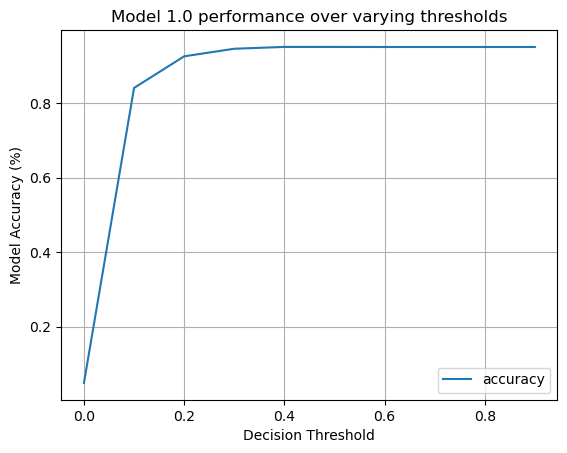

In [25]:
thresholds = np.arange(0, 1, 0.1)

accuracies = []
for p in thresholds:
    accuracies.append(np.mean((y_prob > p) == y))

accuracy_df = pd.DataFrame(index=range(len(thresholds)), 
                           data=zip(thresholds, accuracies), 
                           columns=['Decision Threshold', 'Accuracy'])

display(accuracy_df)

pd.DataFrame(data={'accuracy': accuracies}, index=thresholds).plot(kind="line")
plt.xlabel("Threshold")
plt.title("Model 1.0 performance over varying thresholds")
plt.xlabel('Decision Threshold')
plt.ylabel('Model Accuracy (%)')
plt.grid()
plt.show()

With a decision threshold of only 0.1 we are getting 84% accuracy. This shows that we don't have many stroke predictions to make if our accuracy is that high and our threshold can be set that low. We will need to utilize SMOTE to create a better model from the data but first we can check the coefficients of the model to see what it tells us about each feature so far.

In [26]:
#create a dataframe of coefficients from our model
log_model_df = pd.DataFrame(logreg_results.params, columns=['Coefficient'])
#add an odds ratio column
log_model_df['odds_ratio'] = np.exp(log_model_df['Coefficient']).round(3)

display(log_model_df)

,Coefficient,odds_ratio
const,-7.743784,0.000
age,0.070759,1.073
hypertension,0.404587,1.499
heart_disease,0.292121,1.339
avg_glucose_level,0.004061,1.004
bmi,-0.001324,0.999
gender_Male,0.008921,1.009
gender_Other,-3.353043,0.035
work_type_Never_worked,-16.405281,0.000
work_type_Private,0.267173,1.306


In [27]:
# calculating VIF factors
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.Series([variance_inflation_factor(X_0.values, i) 
               for i in range(X_0.shape[1])], 
              index=X_0.columns)[1:]

age                               1.455107
hypertension                      1.109226
heart_disease                     1.103869
avg_glucose_level                 1.100053
bmi                               1.196977
gender_Male                       1.023509
gender_Other                      1.002291
work_type_Never_worked            1.014630
work_type_Private                 1.086977
Residence_type_Urban              1.002713
smoking_status_formerly smoked    1.536686
smoking_status_never smoked       1.634439
smoking_status_smokes             1.419644
dtype: float64

From the coefficients, it shows that hypertension and heart disease are the best predictors of stroke. <br>

VIF that are less than 3 are not a concern? means there is little correlation and multicolinearity. <BR> 

If we wanted to continue to optimize this model, we could remove the non-significant variables from the data and test our model again iteratively. But due to the severe class imbalance, it would be a better idea to go straight into a SMOTE model.

# SMOTE Modeling <a name="Smote"></a>
- SMOTE, Synthetic Minority Over-sampling Technique
    - generates synthetic samples for the minority class to balance class distribution
    - uses KNN to 
- use smote to over-sample to balance the target class
- create a new logistic model and check accuracy

In [28]:
# to make a smote model, need to make a train and test split because it is an sklearn model
from sklearn.model_selection import train_test_split
# import smote 
from imblearn.over_sampling import SMOTE

In [42]:
# Split the dataset into training and testing sets, do not need to add constant to X
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [61]:
# check target before and after SMOTE resample
print('Without SMOTE:')
print(y_train.value_counts())
print('')
print('With SMOTE:')
print(y_train_resampled.value_counts())

Without SMOTE:
0    3901
1     187
Name: stroke, dtype: int64

With SMOTE:
0    3901
1    3901
Name: stroke, dtype: int64


The unbalanced target class was upsampled from 187 to 3901, similar to the non-stroke class <br>

We can now fit a logisitic model to this data and inspect accuracy

In [60]:
# import logreg model
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg_model = LogisticRegression(max_iter = 1000)

# fit
logreg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on the test data
y_pred_2 = logreg_model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
class_report = classification_report(y_test, y_pred_2)
print("Classification Report:")
print(class_report)

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       960
           1       0.15      0.44      0.23        62

    accuracy                           0.82      1022
   macro avg       0.56      0.64      0.56      1022
weighted avg       0.91      0.82      0.86      1022



The accuracy of the model has decreased to 82%, however, we can view the advanced metrics now <br>




In [62]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_2)
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], 
                            index=['Actual Negative', 'Actual Positive'])

#view matrix
confusion_df

,Predicted Negative,Predicted Positive
Actual Negative,810,150
Actual Positive,35,27
